In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from curlyBrace import curlyBrace
from django.db.models import Exists, OuterRef
import random

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *


In [3]:
qid = 7638
q = Query.objects.get(pk=qid)

In [4]:
dos = DocOwnership.objects.filter(
    query=q,
    relevant=1
)
docs = Doc.objects.filter(pk__in=dos.values_list('doc__id'))
n_docs = docs.count()
print(n_docs)

3252


In [118]:
field_dict = {
    "pk": "Our database ID",
    "title": "Title",
    "content": "Abstract",
    "PY": "Publication Year",
    "wosarticle__di": "DOI",
}
field_dict.keys()

dict_keys(['pk', 'title', 'content', 'PY', 'wosarticle__di'])

In [119]:
fields = list(field_dict.keys())
cs = Category.objects.filter(project=q.project, level__in=[3,4,5])
for c in cs.order_by('level','id'):
    fields.append(c.name)
    dcs = DocCat.objects.filter(
        doc=OuterRef('pk'),
        category=c,
    )
    docs = docs.annotate(**{
        c.name: Exists(dcs)
    })

    
dcs = DocCat.objects.filter(
    doc=OuterRef('pk'),
    category__id=363,
)
docs = docs.annotate(
    db2_inclusion = Exists(dcs)
)

fields.append("db2_inclusion")

field_dict["db2_inclusion"] = "DB2 Inclusion"
    
docs.values(*fields)

<QuerySet [{'pk': 2333830, 'title': "Farming the Floodplain: Ecological and Agricultural Tradeoffs and Opportunities in River and Stream Governance in New England's Changing Climate", 'content': 'In New England (United States) climate change models forecast increasingly intense, frequent floods. Communities in this region are already experiencing these changes, along with the negative consequences associated with them, such as inundation, erosion, natural habitat destruction, and property damage. As it is in many places around the world, agriculture in New England is often in floodplains, which means that farmers are at greater risk due to where they farm. These farmers are already adapting to the increased risk of flooding; however, some of their actions may affect communities downstream, both human and ecological. This case study examines the competing perspectives of farmers and other community stakeholders in New England as farmers work to adapt to increasing flood impacts. Our pre

In [120]:
df = pd.DataFrame.from_dict(docs.values(*fields))[fields]
df = df.rename(columns=field_dict)
df.head()

,Our database ID,Title,Abstract,Publication Year,DOI,Africa,Asia,Australasia,Central & South America,North America,...,"Poverty, livelihoods, and sustainable development",General,Polar Regions,Mountains,Tropical Forests,Cities & settlements by the sea,Biodiversity Hotspots,Mediterranean,"Deserts, semi-arid areas & desertification",DB2 Inclusion
0,2333830,Farming the Floodplain: Ecological and Agricul...,In New England (United States) climate change ...,2017.0,10.1525/cse.2017.sc.512407,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
1,2279660,Participatory action research (PAR) as an entr...,Emerging trends of a changing and increasingly...,2013.0,10.1016/j.envdev.2012.11.001,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,2461130,Climate adaptation practices in building const...,Climate change and increased floods events are...,2018.0,None,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,688401,Climate-smart soil water and nutrient manageme...,There is an increasing need for West African S...,2014.0,10.1186/2048-7010-3-16,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1295127,Evaluating knowledge integration and co-produc...,Although knowledge integration and co-producti...,2018.0,10.1007/s11625-018-0553-6,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [132]:
df.to_csv('doctables/db1_docs.csv')

In [122]:
base_df = df[field_dict.values()]
base_df.head()

,Our database ID,Title,Abstract,Publication Year,DOI,DB2 Inclusion
0,2333830,Farming the Floodplain: Ecological and Agricul...,In New England (United States) climate change ...,2017.0,10.1525/cse.2017.sc.512407,True
1,2279660,Participatory action research (PAR) as an entr...,Emerging trends of a changing and increasingly...,2013.0,10.1016/j.envdev.2012.11.001,False
2,2461130,Climate adaptation practices in building const...,Climate change and increased floods events are...,2018.0,None,True
3,688401,Climate-smart soil water and nutrient manageme...,There is an increasing need for West African S...,2014.0,10.1186/2048-7010-3-16,False
4,1295127,Evaluating knowledge integration and co-produc...,Although knowledge integration and co-producti...,2018.0,10.1007/s11625-018-0553-6,False


In [130]:

for l in [3,4,5]:
    cats = cs.filter(level=l)
    cols = ['Our database ID'] + [c.name for c in cats]
    cat_df = df[cols] 
    var_name = cats.first().parent_category.description.replace('<hidden>','')
    cat_df = cat_df.melt(id_vars=['Our database ID'],var_name=var_name).query('value == True')    
    cat_df = cat_df.drop(['value'], axis=1)
    if l == 3:
        long_df = cat_df
    else:
        long_df = pd.merge(long_df, cat_df)
        
long_df = base_df.merge(long_df)
long_df = long_df.sort_values('Our database ID')

long_df.to_csv('doctables/db1_docs_long.csv')

long_df.head()


    

,Our database ID,Title,Abstract,Publication Year,DOI,DB2 Inclusion,Region,Sector/System,Cross-cutting topics (select only if relevant)
305,3095,Seawalls as a response to coastal erosion and ...,"Many coasts are eroding. In the Comoros, as in...",2017.0,10.1007/s10113-016-1044-x,False,Small Island States,Water quality & sanitation,Cities & settlements by the sea
383,5064,"Pollution, habitat loss, fishing, and climate ...",Cumulative human impacts across the world's oc...,2015.0,10.1111/cobi.12349,False,Global or NA,Terrestrial & freshwater ecosystems,Polar Regions
547,5789,Integrated environmental assessment to explore...,"Al Jabal Al Akhdar, an arid mountain region in...",2016.0,10.1007/s10113-015-0864-4,True,Asia,Water quality & sanitation,"Deserts, semi-arid areas & desertification"
130,14086,Exploring the Knowledge Dynamics Associated wi...,Scientific projections for climate change indu...,2013.0,10.1080/08920753.2013.848747,False,Australasia,"Cities, settlements & key infrastructure",Cities & settlements by the sea
417,21898,"Convinced, ambivalent or annoyed: Tyrolean ski...",Its focus on snow-dependent activities makes A...,2014.0,10.1016/j.tourman.2013.07.010,False,Europe,General,Mountains


In [138]:
dfs = []
for i,l in enumerate([3,4,5]):
    cats = cs.filter(level=l)
    cols = ['Our database ID'] + [c.name for c in cats]
    cat_df = df[cols] 
    var_name = cats.first().parent_category.description.replace('<hidden>','')
    cat_df = cat_df.melt(id_vars=['Our database ID'],var_name="value",value_name="v").query('v == True')    
    cat_df = cat_df.drop(['v'], axis=1)
    cat_df['variable'] = var_name
    dfs.append(cat_df)

very_long_df = pd.concat(dfs)
very_long_df = very_long_df.sort_values(['Our database ID','variable']).reset_index(drop=True)
very_long_df = very_long_df[['Our database ID', 'variable', 'value']]
very_long_df = base_df.merge(very_long_df)
very_long_df.to_csv('doctables/db1_docs_very_long.csv')
very_long_df.head()

,Our database ID,Title,Abstract,Publication Year,DOI,DB2 Inclusion,variable,value
0,2333830,Farming the Floodplain: Ecological and Agricul...,In New England (United States) climate change ...,2017.0,10.1525/cse.2017.sc.512407,True,Region,North America
1,2333830,Farming the Floodplain: Ecological and Agricul...,In New England (United States) climate change ...,2017.0,10.1525/cse.2017.sc.512407,True,Sector/System,"Food, fibre, and other ecosystem products"
2,2333830,Farming the Floodplain: Ecological and Agricul...,In New England (United States) climate change ...,2017.0,10.1525/cse.2017.sc.512407,True,Sector/System,Water quality & sanitation
3,2279660,Participatory action research (PAR) as an entr...,Emerging trends of a changing and increasingly...,2013.0,10.1016/j.envdev.2012.11.001,False,Region,North America
4,2279660,Participatory action research (PAR) as an entr...,Emerging trends of a changing and increasingly...,2013.0,10.1016/j.envdev.2012.11.001,False,Sector/System,"Food, fibre, and other ecosystem products"


In [139]:
very_long_df['variable'].unique()

array(['Region', 'Sector/System ',
       'Cross-cutting topics (select only if relevant) '], dtype=object)

Africa
886
Asia
907
Australasia
186
Central & South America
222
Europe
443
Global or NA
181
North America
351
Small Island States
93
0
1
2


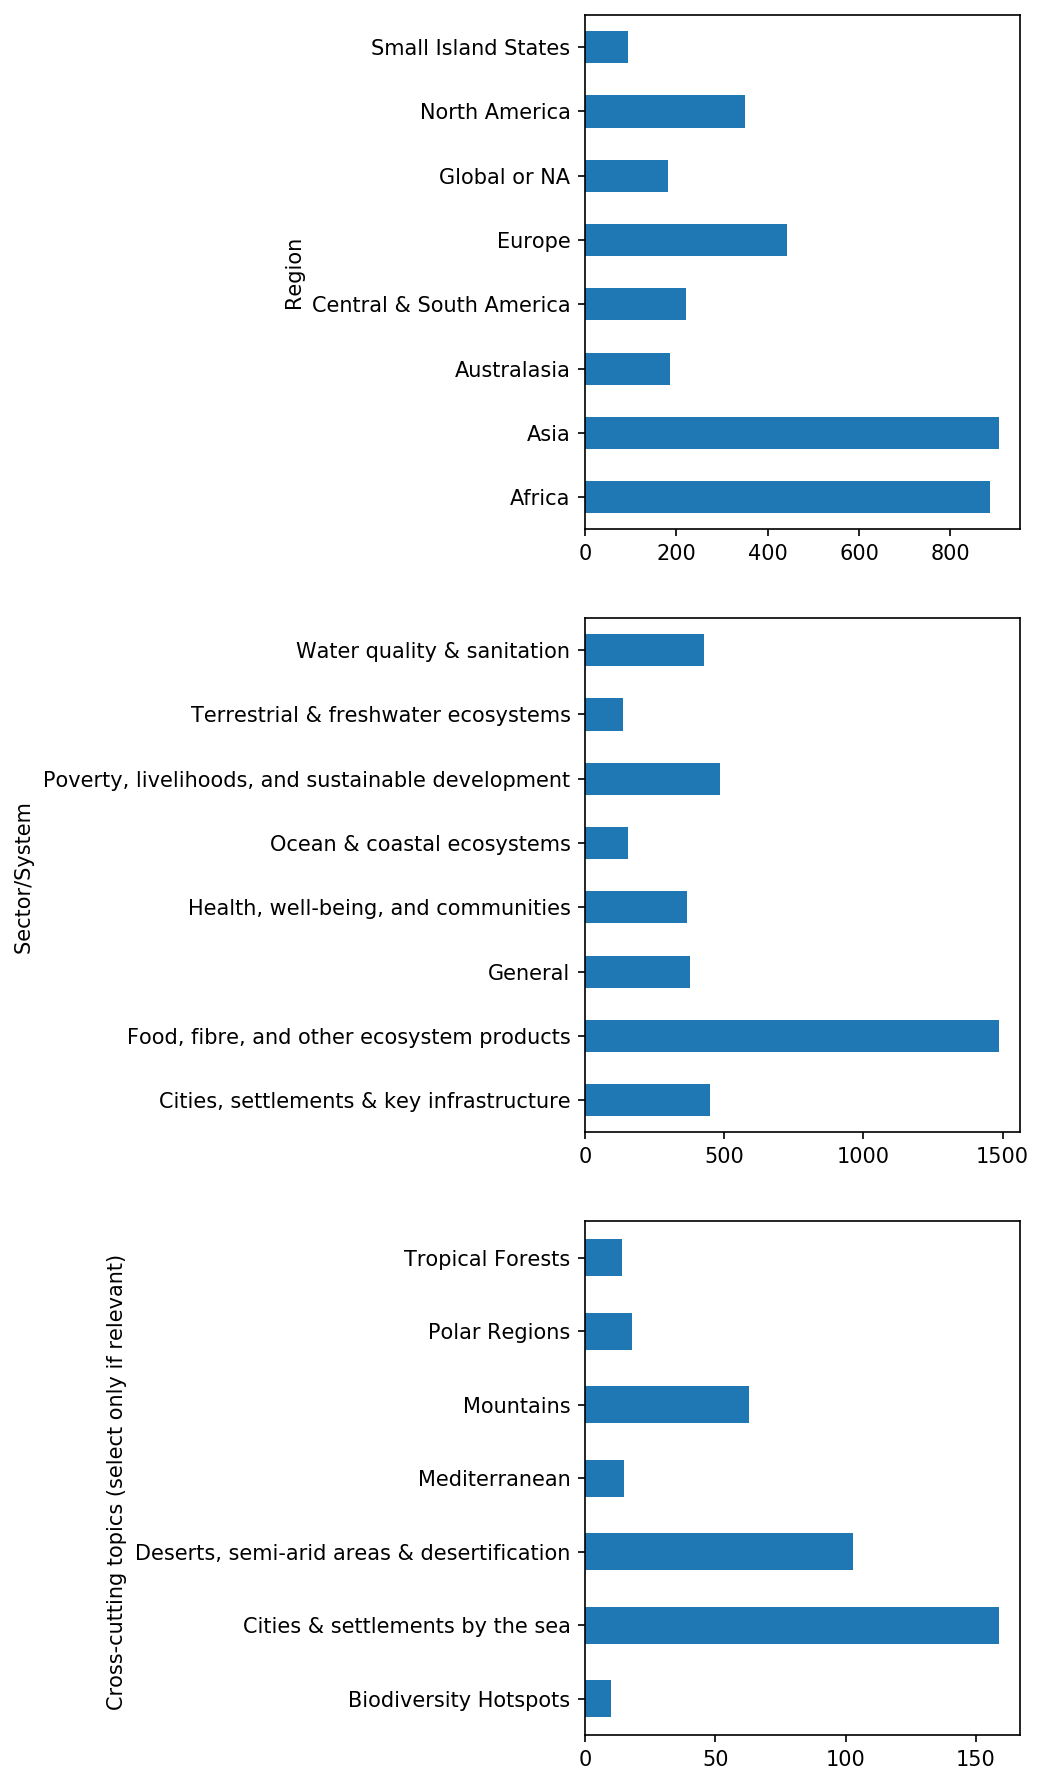

In [164]:
fig = plt.figure(figsize=(7,12),dpi=150)

for i, (name, group) in enumerate(very_long_df.query('variable == "Region"').groupby('value')):    
    print(name)
    print(group.shape[0])
    
for i,x in enumerate(very_long_df['variable'].unique()):
    ax = fig.add_subplot(3,1,i+1)
    print(i)
    very_long_df[very_long_df['variable'] == x].groupby('value').count()['Title'].plot(kind="barh", ax=ax)
    ax.set_ylabel(x)
    
    
fig.tight_layout()

In [168]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(8,8), dpi=180)

ax = plt.axes(projection=ccrs.Mollweide())

ModuleNotFoundError: No module named 'cartopy'